<a href="https://colab.research.google.com/github/mohammadsanaee/DE_calculator/blob/master/4_neural_networks_backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
#@title <b><font color="red">▶</font><font color="black"> run this cell and restart runtime</font></b>

!pip install -q networkx

In [71]:
#@title <b><font color="red">▶</font><font color="black"> run this cell to prepare supplementary materials for the lesson</font></b>

!rm -rf harbour-space-text-mining-course
!git clone https://github.com/horoshenkih/harbour-space-text-mining-course.git

import sys
if 'harbour-space-text-mining-course' not in sys.path:
    sys.path.append('harbour-space-text-mining-course')

from tmcourse.demo import (
    demo_function_approximation,
    demo_gradient_descent,
    demo_computational_graph,
    demo_universal_approximator,
    demo_pytorch_computational_graph,
    demo_2d_classification,
)
from tmcourse.quiz import (
    quiz_bumps,
    quiz_derivative,
    quiz_correct_computational_graph,
    quiz_derivative_pytorch,
)
from tmcourse.ipyquiz import Quiz, Function
from tmcourse.utils import enable_mathjax_in_cell

from IPython.display import HTML, display

# get_ipython().events.register('pre_run_cell', enable_mathjax_in_cell)
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 6.0)


Cloning into 'harbour-space-text-mining-course'...
remote: Enumerating objects: 738, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 738 (delta 79), reused 158 (delta 69), pack-reused 563
Receiving objects: 100% (738/738), 179.50 MiB | 25.05 MiB/s, done.
Resolving deltas: 100% (403/403), done.
Checking out files: 100% (129/129), done.


<!--@slideshow slide-->
<h1><center>Backpropagation. Neural networks.</center></h1>


<!--@slideshow slide-->

# Outline
1. A universal approximator
2. Train the universal approximator with gradient descent
3. Computational graphs and backpropagation
4. Layers: forward-backward API
5. XOR problem: add more layers
6. Feedforward neural networks
7. PyTorch basics

<!--@slideshow slide-->
# A universal approximator


<!--@slideshow fragment-->
Consider the regression problem: approximate the unknown function $f(x)$ given the finite set of values $\{(x_n, f(x_n)\}_{1\leq n \leq N}$.

<!--@slideshow fragment-->
In practice, we always want the approximation to be computationally efficient.

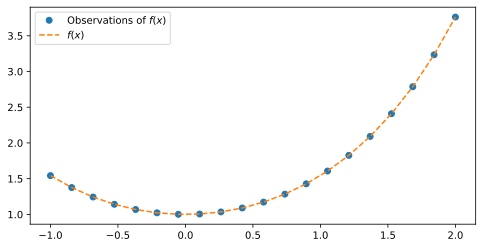

In [72]:
#@slideshow fragment tags=remove_input

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
x = np.linspace(-1, 2, 20)
y = np.cosh(x)

plt.figure(figsize=(8, 4))
plt.plot(x, y, 'o')
plt.plot(x, y, '--')
plt.legend([r"Observations of $f(x)$", r"$f(x)$"])

plt.show()

<!--@slideshow slide-->

The simplest approximation is a linear model $ax+b$.
Clearly, it is not always good.

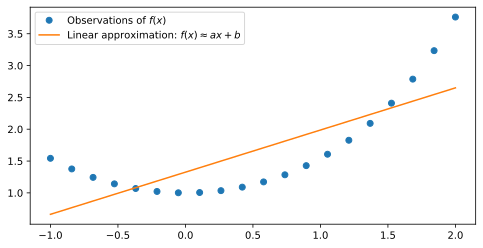

In [73]:
#@slideshow fragment tags=remove_input

plt.figure(figsize=(8, 4))
linear_approximation = np.poly1d(np.polyfit(x, y, 1))
plt.plot(
    x, y, 'o',
    x, linear_approximation(x), '-'
)
plt.legend([r"Observations of $f(x)$", r"Linear approximation: $f(x) \approx ax + b$"])
plt.show()

<!--@slideshow slide-->
**Theorem**: any function can be approximated with the linear combination of nonlinear functions which linearly depend on $x$:
$$
f(x) \approx \sum\limits_{1 \leq k \leq K} w_k \cdot g(a_k x+b_k)
$$
$K$ is a hyperparameter (the number of nonlinear terms) and $g$ is any nonlinear function (also a hyperparameter).

<!--@slideshow fragment-->
We will prove it using the _Heaviside function_ as the function $g$:
$$
g(x) = \begin{cases} 1 & \text{if } x \geq 0 \\
0 & \text{otherwise}
\end{cases}
$$

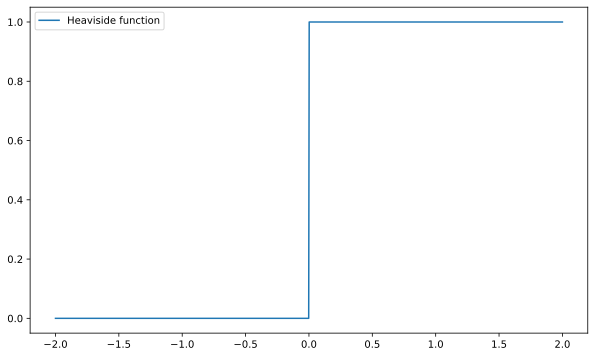

In [74]:
#@slideshow slide tags=remove_input

X = np.linspace(-2, 2, 1000)
plt.plot(X, np.heaviside(X, 1), '-')
plt.legend(["Heaviside function"])
plt.show()

<!--@slideshow slide-->
### Exercise 1
Prove that the Heaviside function is nonlinear.

**Hint**: if a function $f(x)$ is linear, then $f(x_1 + x_2) = f(x_1) + f(x_2)$ for all $x_1$, $x_2$.

<!--@slideshow slide-->
Why is the Heaviside function is sufficient to approximate $f(x) \approx \sum\limits_{1 \leq k \leq K} w_k \cdot g(a_k x+b_k)$?


<!--@slideshow fragment-->
Consider the term $w \cdot g(ax + b)$. Each parameter $w, a, b$ corresponds to a certain transformation.

<!--@slideshow slide-->
The coefficient $b$ shifts left or right.

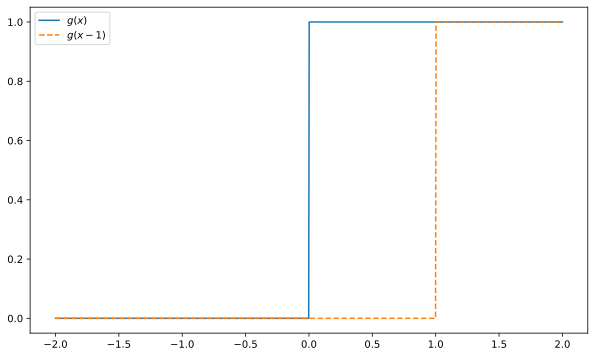

In [75]:
#@slideshow fragment tags=remove_input

X = np.linspace(-2, 2, 1000)
plt.plot(
    X, np.heaviside(X, 1), '-',
    X, np.heaviside(X - 1, 1), '--'
)
plt.legend([r"$g(x)$", r"$g(x-1)$"])
plt.show()

<!--@slideshow slide-->
The coefficient $a$ mirrors.

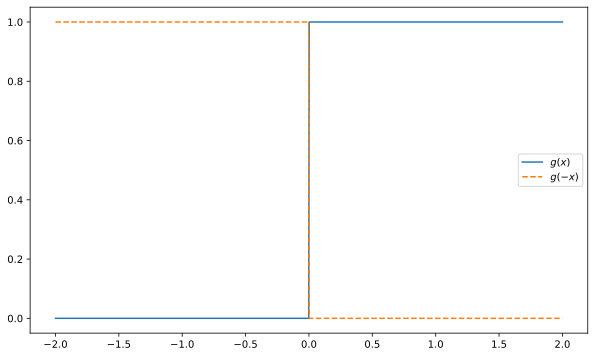

In [76]:
#@slideshow fragment tags=remove_input

X = np.linspace(-2, 2, 1000)
plt.plot(
    X, np.heaviside(X, 1), '-',
    X, np.heaviside(-X, 1), '--'
)
plt.legend([r"$g(x)$", r"$g(-x)$"])
plt.show()

<!--@slideshow slide-->
The coefficient $w$ scales.

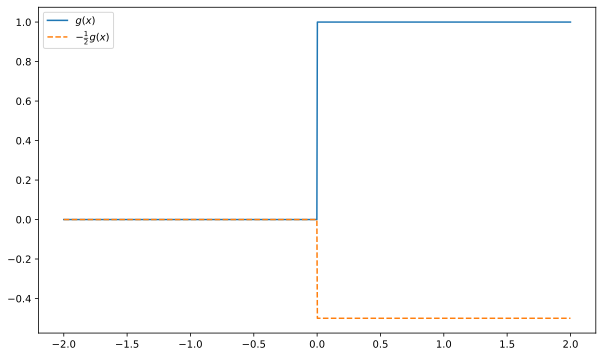

In [77]:
#@slideshow fragment tags=remove_input

X = np.linspace(-2, 2, 1000)
plt.plot(
    X, np.heaviside(X, 1), '-',
    X, -0.5 * np.heaviside(X, 1), '--'
)
plt.legend([r"$g(x)$", r"$-\frac{1}{2}g(x)$"])
plt.show()

<!--@slideshow slide-->
**Idea**: use Heaviside functions $g$ to construct a "bump" of height $h$ in the interval $[x_0, x_1]$:
$$\Pi_{x_0, x_1, h}(x) = \begin{cases} h & \text{if } x_0 \leq x \leq x_1 \\
0 & \text{otherwise}
\end{cases}$$

using the formula:
$$
\Pi_{x_0, x_1, h}(x) = \frac{h}{2}g(x-x_0) + \frac{h}{2}g(-(x-x_1)) - \frac{h}{2}g(-(x-x_0)) - \frac{h}{2}g(x-x_1)
$$

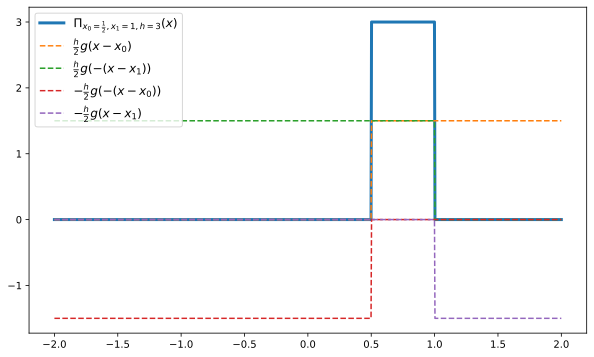

In [78]:
#@slideshow slide tags=remove_input

X = np.linspace(-2, 2, 1000)

plt.plot(
    X,
    1.5 * np.heaviside(X - 0.5, 1) + 1.5 * np.heaviside(-(X - 1), 1)-1.5 * np.heaviside(-X + 0.5, 1)-1.5 * np.heaviside(X - 1, 1),
    '-',
    linewidth=3.0
)
plt.plot(
    X, 1.5 * np.heaviside(X - 0.5, 1), '--',
    X, 1.5 * np.heaviside(-(X - 1), 1), '--',
    X, -1.5 * np.heaviside(-X + 0.5, 1), '--',
    X, -1.5 * np.heaviside(X - 1, 1), '--',
)
plt.legend(
    [
        r"$\Pi_{x_0=\frac{1}{2}, x_1=1, h=3}(x)$",
        r"$\frac{h}{2}g(x-x_0)$",
        r"$\frac{h}{2}g(-(x-x_1))$",
        r"$-\frac{h}{2}g(-(x-x_0))$",
        r"$-\frac{h}{2}g(x-x_1)$",
    ],
    fontsize="large"
)
plt.show()

<!--@slideshow slide-->
Using "bumps", we can make a piecewise-constant approximation of any function $f(x)$.

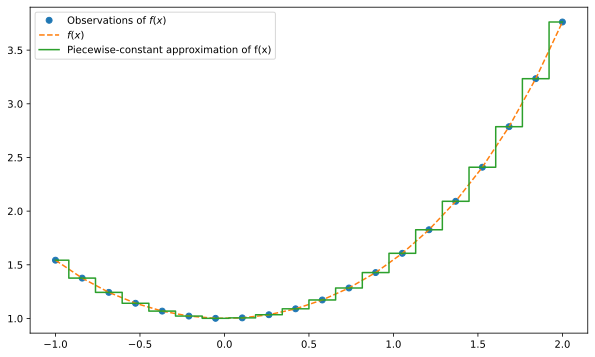

In [79]:
#@slideshow fragment tags=remove_input

plt.plot(x, y, 'o')
plt.plot(x, y, '--')

x_approx = []
y_approx = []
for i in range(len(x)):
    if i == 0:
        dleft = 0
    else:
        dleft = x[i] - x[i-1]
    if i == len(x) - 1:
        dright = 0
    else:
        dright = x[i+1] - x[i]
    x_approx.append(x[i] - dleft/2)
    y_approx.append(y[i])
    x_approx.append(x[i] + dright/2)
    y_approx.append(y[i])
plt.plot(x_approx, y_approx, '-')
plt.legend([r"Observations of $f(x)$", r"$f(x)$", "Piecewise-constant approximation of f(x)"])

plt.show()

<!--@slideshow slide-->
### Colab demo 1: function approximation

In the demo `demo_function_approximation()` we can try as $g$:
- `step` - the step, or Heaviside, function
- `relu` - Rectified Linear Unit: $g(x) = \max(0, x)$

The hyperparameter $K$ is set by `num_functions`.

For example, try to construct a bump $\Pi_{x_0, x_1, h}(x)$ using the formula
$$
\Pi_{x_0, x_1, h}(x) = \frac{h}{2}g(x-x_0) + \frac{h}{2}g(-(x-x_1)) - \frac{h}{2}g(-(x-x_0)) - \frac{h}{2}g(x-x_1)
$$

<!--@slideshow fragment-->


In [80]:
demo_function_approximation(num_functions=4)

<!--@slideshow slide-->
## Colab quiz 1
Choose the correct approximation.

In [81]:
enable_mathjax_in_cell()
quiz_bumps()()

<!--@slideshow slide-->
# Train the universal approximator with gradient descent




<!--@slideshow slide-->
Our goal is to find a function of the form
$$
h(x) = \sum\limits_{1 \leq i \leq K} w_k g(a_k x + b_k)
$$
which approximates $f(x)$ the best.

<!--@slideshow fragment-->

All we know about $f(x)$ is the set of $N$ input-output pairs $\lbrace(x_n, f(x_n))\rbrace_{1 \leq n \leq N}$.

Let's denote **feature matrix** $X = \{ x_n \}_{1 \leq n \leq N}$ and **target vector** $y = \{ f(x_n) \}_{1 \leq n \leq N}$.

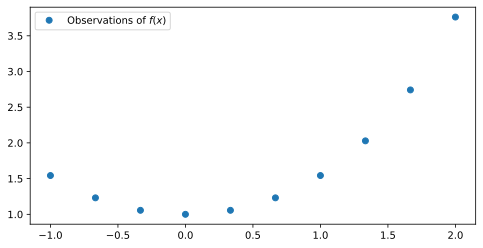

In [82]:
#@slideshow fragment tags=remove_input
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-1, 2, 10)
y = np.cosh(x)

plt.figure(figsize=(8, 4))
plt.plot(x, y, 'o')
plt.legend([r"Observations of $f(x)$"])

plt.show()

<!--@slideshow slide-->
The standard machine learning approach is:

<!--@slideshow slide-->
**Step 1.** Somehow choose _hyperparameters_ $K$, $g$. There are still many functions $h(x)$!

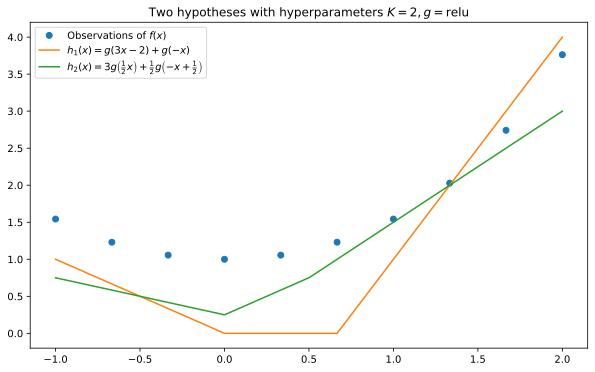

In [83]:
#@slideshow fragment tags=remove_input

relu = lambda x: np.maximum(x, 0)
h1 = lambda x: relu(3*x - 2)
x_smooth = np.linspace(-1, 2, 500)
h1 = lambda x: relu(3*x - 2) + relu(-x)
h2 = lambda x: 3*relu(0.5*x) + 0.5*relu(-x+0.5)

plt.plot(x, y, 'o', x_smooth, h1(x_smooth), x_smooth, h2(x_smooth))
plt.title(r"Two hypotheses with hyperparameters $K=2, g = \mathrm{relu}$")
plt.legend(
    [
        r"Observations of $f(x)$",
        r"$h_1(x) = g(3x-2) + g(-x)$",
        r"$h_2(x) = 3g\left(\frac{1}{2}x\right) + \frac{1}{2}g\left(-x+\frac{1}{2}\right)$",
    ]
)

plt.show()

<!--@slideshow slide-->
**Step 2.** Decide how to measure the difference between a hypothesis $h(x)$ and observations $X, y$.
This measure is called **loss function** $L(x, y, h)$.


<!--@slideshow fragment-->
A loss function is usually the average value of individual losses $\ell$ for each observation:
$$
L(x, y, h) = \dfrac{1}{N}\sum\limits_{1 \leq n \leq N} \ell(y_n, h(x_n))
$$

<!--@slideshow fragment-->
For example, **mean squared error (MSE)** loss is given by $\ell(y, h) = \frac{1}{2}(y - h)^2$.

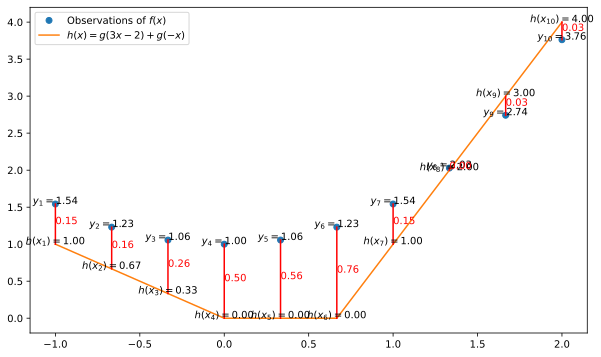

In [84]:
#@slideshow slide tags=remove_input

relu = lambda x: np.maximum(x, 0)
x_smooth = np.linspace(-1, 2, 500)
h1 = lambda x: relu(3*x - 2) + relu(-x)

plt.plot(x, y, 'o', x_smooth, h1(x_smooth))
losses = []
for i, item in enumerate(zip(x, y)):
    n = i+1
    xi, yi = item
    l = 0.5 * (yi - h1(xi))**2
    losses.append(l)
    plt.plot([xi, xi], [yi, h1(xi)], c="r")
    plt.annotate(r"$y_{{{}}} = {:.2f}$".format(n, yi), (xi, yi), ha='center')
    plt.annotate(r"$h(x_{{{}}}) = {:.2f}$".format(n, h1(xi)), (xi, h1(xi)), ha='center')
    plt.annotate("{:.2f}".format(l), (xi, 0.5*(yi + h1(xi))), c="r")

plt.legend(
    [
        r"Observations of $f(x)$",
        r"$h(x) = g(3x-2) + g(-x)$",
    ]
)

plt.show()

display(
    HTML(
        r"$L(X, y, h) = \dfrac{1}{N}\sum_{1 \leq n \leq N}\frac{1}{2}(y_n-h(x_n))^2=" + r"{:.2f}$".format(np.mean(losses))
    )
)

<!--@slideshow slide-->
**Step 3.** Minimize the loss function $L(X, y, h)$ using **gradient descent**.

<!--@slideshow fragment-->
What does $L(X, y, h)$ depend on?
- Observations $X, y$: cannot change them at all
- Hyperparameters $K, g$ of function $h$: chosen and fixed


<!--@slideshow fragment-->
Recall that 
$$
h(x) = \sum\limits_{1 \leq k \leq K} w_k \cdot g(a_k x+b_k)
$$
So $L(x, y, h)$ ultimately depends on parameters $a_1, \dots, a_K, b_1, \dots, b_k, w_1, \dots, w_k$:
$$
L(X, y, h) = L(a_1, \dots, a_K, b_1, \dots, b_K, w_1, \dots, w_K)
$$

<!--@slideshow fragment-->
To simplify the notation, we will denote the set of parameters as $\theta$:
$$\theta = \{a_k, b_k, w_k\}_{1 \leq k \leq K}$$
So $L(X, y, h)$ becomes just $L(\theta)$.

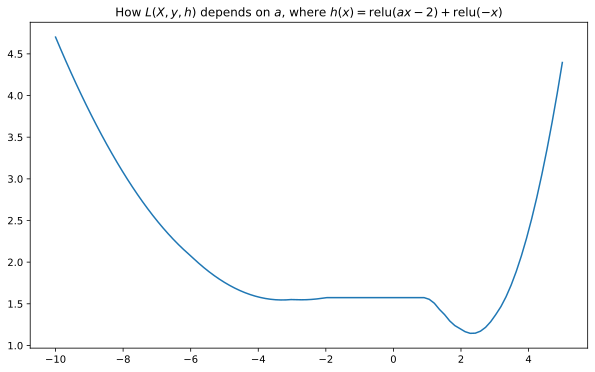

In [85]:
#@slideshow slide tags=remove_input

h_ = lambda x, w: relu(w*x - 2) + relu(-x)
L = lambda w: np.mean([0.5 * (y_i - h_(x, w))**2 for (x_i, y_i) in zip(x, y)])

w_range = np.linspace(-10, 5, 100)
plt.plot(w_range, [L(w) for w in w_range])
plt.title(r"How $L(X, y, h)$ depends on $a$, where $h(x) = \mathrm{relu}(ax - 2) + \mathrm{relu}(-x)$")
plt.show()

<!--@slideshow slide-->
We need to find parameters $\theta$ that give the lowest value of $L(\theta)$.

It can be done via **gradient descent**:
1. Choose the initial values of parameters $\theta^{(0)}$
2. Compute **the gradient** of $L$ wrt $\theta$ at the point $\theta^{(0)}$:
$$
\nabla L(\theta^{(0)}) = \left(\dfrac{\partial L}{\partial \theta^{(0)}_1}(\theta^{(0)}), \dfrac{\partial L}{\partial \theta^{(0)}_2}(\theta^{(0)}), \dots\right)^T
$$
3. Move in the direction of negative gradient (steepest descent):
$$
\theta^{(1)} = \theta^{(0)} - \lambda \nabla L(\theta^{(0)})
$$
Step size $\lambda$ is called **learning rate**.
4. Repeat until convergence.

<!--@slideshow slide-->
### Colab demo 2: gradient descent

In [86]:
demo_gradient_descent(lambda x: x**4 - x**3 - x**2 + 1, theta_0=-1, learning_rate=0.05)  # local minima

In [87]:
demo_gradient_descent(lambda x: x**2, theta_0=-1, learning_rate=1.1)  # divergence

<!--@slideshow slide-->
How do we find the gradient $\nabla L(\theta)$?


<!--@slideshow slide-->
**Option 1. Numerical estimation.**

$\dfrac{\partial L}{\partial \theta_i}$ can be estimated as
$$
\dfrac{\partial L}{\partial \theta_i} \approx \dfrac{L(\theta_i + \delta) - L(\theta_i - \delta)}{2 \delta}
$$

<!--@slideshow fragment-->
Problems:
1. Not exact
1. Too expensive
  - **Each parameter** $\theta_i$ requires 2 evaluations of $L$
  - The total complexity is proportional to the number of parameters $\theta$

<!--@slideshow slide-->
## Exercise 2

Consider the univariate function $f(x)$ with the derivative $f'(x)$.

Prove that the estimation of the derivative
$$
f'(x) \approx d_1(x) = \dfrac{f(x + \delta) - f(x - \delta)}{2 \delta}
$$
is more precice than the "naïve" estimation
$$
f'(x) \approx d_2(x) = \dfrac{f(x + \delta) - f(x)}{\delta}
$$
in the following sense:
$$|f'(x) - d_1(x)| = O(\delta^2)\textrm{ for all }x$$
$$|f'(x) - d_2(x)| = O(\delta)\textrm{ for all }x$$

**Hint:** use Taylor series of $f$ at $x$.

<!--@slideshow slide-->
**Option 2. Analytical differentiation**

<!--@slideshow fragment-->
Recall that the loss function is the average of individual losses:
$$
L(X, y, h) = \dfrac{1}{N}\sum\limits_{1 \leq n \leq N} \ell(y_n, h(x_n))
$$

So it is sufficient to calculate the derivative of $\ell(y, h(x))$ wrt $a_1, \dots, a_K, b_1, \dots, b_K, w_1, \dots, w_K$.


<!--@slideshow slide-->
$$
\dfrac{\partial \ell}{\partial w_k} = 
$$


<!--@slideshow fragment-->
$$
= \dfrac{\partial}{\partial w_k}\frac{1}{2}(y - h(x))^2 = 
$$


<!--@slideshow fragment-->
$$
= \underbrace{(y - h(x))}_{\frac{\partial \ell}{\partial h}} \cdot \dfrac{\partial h}{\partial w_k} = 
$$


<!--@slideshow fragment-->
$$
= \underbrace{(y - h(x))}_{\frac{\partial \ell}{\partial h}} \cdot \underbrace{g(a_k x + b_k)}_{\frac{\partial h}{\partial w_k}}
$$

<!--@slideshow slide-->
$$
\dfrac{\partial \ell}{\partial a_k} = 
$$


<!--@slideshow fragment-->
$$
= \dfrac{\partial}{\partial a_k}\frac{1}{2}(y - h(x))^2 = 
$$


<!--@slideshow fragment-->
$$
= \underbrace{(y - h(x))}_{\frac{\partial \ell}{\partial h}} \cdot \dfrac{\partial h}{\partial a_k} = 
$$


<!--@slideshow fragment-->
$$
= \underbrace{(y - h(x))}_{\frac{\partial \ell}{\partial h}} \cdot \underbrace{w_k}_{\frac{\partial h}{\partial g}} \cdot \underbrace{g'(a_k x + b_k) \cdot x}_{\frac{\partial g(a_k x + b)}{\partial a_k}}
$$

<!--@slideshow slide-->
$$
\dfrac{\partial \ell}{\partial b_k} = 
$$



<!--@slideshow fragment-->
$$
= \dfrac{\partial}{\partial b_k}\frac{1}{2}(y - h(x))^2 = 
$$


<!--@slideshow fragment-->
$$
= \underbrace{(y - h(x))}_{\frac{\partial l}{\partial h}} \cdot \dfrac{\partial h}{\partial b_k} = 
$$


<!--@slideshow fragment-->
$$
= \underbrace{(y - h(x))}_{\frac{\partial l}{\partial h}} \cdot \underbrace{w_k}_{\frac{\partial h}{\partial g}} \cdot \underbrace{g'(a_k x + b_k)}_{\frac{\partial g(a_k x + b_k)}{\partial b_k}}
$$

<!--@slideshow slide-->
Analytical inference is exact, but it should be performed for each $\ell$ and $h$ from scratch.
<!--@slideshow fragment-->
For example, if instead of $h$ we use
$$
\tilde h(x) = \sum\limits_{1 \leq k \leq K} w_k g(a_k x + b_k) \color{red}{+ s_k}
$$
then we need to compute all the derivatives $\dfrac{\partial \ell}{\partial s_k}$.

<!--@slideshow slide-->
## Colab quiz 2
Choose the correct derivative.

In [88]:
enable_mathjax_in_cell()
quiz_derivative()()

<!--@slideshow slide-->
Fortunately, computation of derivatives can be done **algorithmically** in a very efficient way.

Note that the expressions
$$
\dfrac{\partial \ell}{\partial w_k} = \underbrace{(y - h(x))}_{\frac{\partial \ell}{\partial h}} \cdot \underbrace{g(a_k x + b_k)}_{\frac{\partial h}{\partial w_k}}
$$

$$
\dfrac{\partial \ell}{\partial a_k} = \underbrace{(y - h(x))}_{\frac{\partial \ell}{\partial h}} \cdot \underbrace{w_k}_{\frac{\partial h}{\partial g}} \cdot \underbrace{g'(a_k x + b_k) \cdot x}_{\frac{\partial g(a_k x + b)}{\partial a_k}}
$$

$$
\dfrac{\partial \ell}{\partial b_k} =\underbrace{(y - h(x))}_{\frac{\partial l}{\partial h}} \cdot \underbrace{w_k}_{\frac{\partial h}{\partial g}} \cdot \underbrace{g'(a_k x + b_k)}_{\frac{\partial g(a_k x + b_k)}{\partial b_k}}
$$
have common parts:
- all of them share $\dfrac{\partial \ell}{\partial h}$
- $\dfrac{\partial \ell}{\partial a_k}$, $\dfrac{\partial \ell}{\partial b_k}$ also share $\dfrac{\partial h}{\partial g}$

This observation brings us to

**Option 3. Computational graphs and backpropagation.**

<!--@slideshow slide-->
# Computational graphs and backpropagation

**Our goal**: compute the derivative of a multivariate function $F$.

**Example**: $F(\alpha, \beta) = f(\alpha \cdot \beta)$, where $f$ is a scalar function with the derivative $f'$.


<!--@slideshow slide-->
$$
\dfrac{\partial F}{\partial \alpha}(\alpha, \beta) 
$$


<!--@slideshow fragment-->
$$
= \dfrac{\partial f}{\partial \alpha}(\alpha \cdot \beta)
$$


<!--@slideshow fragment-->
$$
= f'(\alpha \cdot \beta) \dfrac{\partial (\alpha \cdot \beta)}{\partial \alpha}
$$


<!--@slideshow fragment-->
$$
= \beta f'(\alpha \cdot \beta)
$$


<!--@slideshow slide-->
$$
\dfrac{\partial F}{\partial \beta}(\alpha, \beta)
$$


<!--@slideshow fragment-->
$$= \dfrac{\partial f}{\partial \beta}(\alpha \cdot \beta)
$$


<!--@slideshow fragment-->
$$= f'(\alpha \cdot \beta) \dfrac{\partial (\alpha \cdot \beta)}{\partial \beta}
$$


<!--@slideshow fragment-->
$$= \alpha f'(\alpha \cdot \beta)
$$

<!--@slideshow slide-->
## Colab demo: computational graph

In [89]:
alpha = r"$\alpha$"
beta = r"$\beta$"
mul = r"$\times$"
f = r"$f$"

connections = [
    (alpha, mul, r"$\alpha$", r"$\beta f'(\alpha \cdot \beta)$" "\n" r"$\left[\dfrac{\partial (\alpha\cdot\beta)}{\partial\alpha} = \beta\right]$"),
    (beta, mul, r"$\beta$", r"$\alpha f'(\alpha \cdot \beta)$" "\n" r"$\left[\dfrac{\partial (\alpha\cdot\beta)}{\partial\beta} = \alpha\right]$"),
    (mul, f, r"$\alpha\cdot\beta$", r"$f'(\alpha \cdot \beta)$" "\n" r"$\left[ \dfrac{\partial f(\alpha\cdot\beta)}{\partial(\alpha\cdot\beta)} = f'(\alpha\cdot\beta) \right]$"),
]
demo_computational_graph(connections, title=r"$F(\alpha, \beta) = f(\alpha \cdot \beta$)")

<!--@slideshow slide-->
The computational graph suggests the following algorithm to compute derivatives:


<!--@slideshow fragment-->
each node $n$ with inputs $i_1, i_2, \dots$


<!--@slideshow fragment-->
  - Receives the derivative of $F$ w.r.t. its value $\dfrac{\partial F}{\partial n}$


<!--@slideshow fragment-->
  - Computes the derivatives of its value w.r.t. its inputs: $\dfrac{\partial n}{\partial i_1}, \dfrac{\partial n}{\partial i_2}, \dots$


<!--@slideshow fragment-->
  - For each input $i_k$, **propagates back** the derivatives of $F$ wrt $i_k$ using chain rule: $\dfrac{\partial F}{\partial i_k} = \dfrac{\partial F}{\partial n} \cdot \dfrac{\partial n}{\partial i_k}$
  


<!--@slideshow fragment-->
This algorithm is called **backpropagation**.

<!--@slideshow slide-->
## Colab demo: more examples of backpropagation

**Example**: $F(\alpha, \beta) = f(\alpha + \beta)$
$$
\dfrac{\partial F}{\partial \alpha}(\alpha, \beta) = \dfrac{\partial f}{\partial \alpha}(\alpha + \beta) = f'(\alpha + \beta) \dfrac{\partial (\alpha + \beta)}{\partial \alpha} = f'(\alpha + \beta)
$$
$$
\dfrac{\partial F}{\partial \beta}(\alpha, \beta) = \dfrac{\partial f}{\partial \beta}(\alpha + \beta) = f'(\alpha + \beta) \dfrac{\partial (\alpha + \beta)}{\partial \beta} = f'(\alpha + \beta)
$$


In [90]:
alpha = r"$\alpha$"
beta = r"$\beta$"
plus = r"$+$"
f = r"$f$"

connections = [
    (alpha, plus, r"$\alpha$", r"$f'(\alpha + \beta)$"),
    (beta, plus, r"$\beta$", r"$f'(\alpha + \beta)$"),
    (plus, f, r"$\alpha + \beta$", r"$f'(\alpha + \beta)$"),
]
demo_computational_graph(connections, title=r"$F(\alpha, \beta) = f(\alpha + \beta)$")

**Example:** $F(\alpha) = f(g(\alpha))$, where $g$ is a univariate function with the derivative $g'$.
$$
\dfrac{\partial F}{\partial \alpha}(\alpha) = \dfrac{\partial f(g(\alpha))}{\partial \alpha} = \dfrac{\partial f}{\partial g}(g(\alpha)) \cdot \dfrac{\partial g(\alpha)}{\partial \alpha} = f'(g(\alpha))\cdot g'(\alpha)
$$

In [91]:
alpha = r"$\alpha$"
g = r"$g$"
f = r"$f$"

connections = [
    (alpha, g, r"$\alpha$", r"$f'(g(\alpha)) \cdot g'(\alpha)$"),
    (g, f, r"$g(\alpha)$", r"$f'(g(\alpha))$"),
]
demo_computational_graph(connections, title=r"$F(\alpha) = f(g(\alpha))$")

<!--@slideshow slide-->
## Colab quiz 3

In [92]:
enable_mathjax_in_cell()
quiz_correct_computational_graph()()

**Example**: $F(\alpha, \beta, \gamma) = f(\alpha \ln \beta + 3\gamma)$

In [93]:
alpha = r"$\alpha$"
beta = r"$\beta$"
gamma = r"$\gamma$"
ln = r"$\ln$"
f = r"$f$"
plus = r"$+$"
mul = r"$\times$"
mul3 = r"$\times 3$"

connections = [
    (alpha, mul, r"$\alpha$", r"$\ln\beta f'(\alpha\ln\beta + 3\gamma)$"),
    (beta, ln, r"$\beta$", r"$\dfrac{\alpha}{\beta}f'(\alpha\ln\beta + 3\gamma)$" "\n" r"$\left[\dfrac{\partial\ln\beta}{\partial\beta} = \dfrac{1}{\beta}\right]$"),
    (ln, mul, r"$\ln\beta$", r"$\alpha f'(\alpha\ln\beta + 3\gamma)$"),
    (mul, plus, r"$\alpha\ln\beta$", r"$f'(\alpha\ln\beta + 3\gamma)$"),
    (gamma, mul3, r"$\gamma$", r"$3f'(\alpha\ln\beta + 3\gamma)$" "\n" r"$\left[\dfrac{\partial (3\cdot\gamma)}{\partial \gamma} = 3\right]$"),
    (mul3, plus, r"$3\gamma$", r"$f'(\alpha\ln\beta + 3\gamma)$"),
    (plus, f, r"$\alpha\ln\beta + 3\gamma$", r"$f'(\alpha\ln\beta + 3\gamma)$")
]
demo_computational_graph(
    connections,
    title=r"$F(\alpha, \beta, \gamma) = f(\alpha\ln\beta + 3\gamma$)",
    font_size=15,
    node_size=400
)

<!--@slideshow slide-->

A node of computational graph may have many _outputs_.

**Example**: $F(t) = x(t) \times e^{y(t)}$.

$F$ depends on $x$ and $y$ that depend on $t$.


<!--@slideshow fragment-->
**Solution**: use _total derivative_.


<!--@slideshow fragment-->
The connection between $\Delta F, \Delta x, \Delta y$ and partial derivatives:

$$\Delta F \approx \Delta x \dfrac{\partial F}{\partial x} + \Delta y \dfrac{\partial F}{\partial y}$$


<!--@slideshow fragment-->
Divide both sides by $\Delta t$:
$$\dfrac{\Delta F}{\Delta t} \approx \dfrac{\Delta x}{\Delta t} \dfrac{\partial F}{\partial x} + \dfrac{\Delta y}{\Delta t} \dfrac{\partial F}{\partial y} $$


<!--@slideshow fragment-->
$$\Rightarrow \dfrac{d F}{d t} = \dfrac{d x}{d t} \dfrac{\partial F}{\partial x} + \dfrac{d y}{d t} \dfrac{\partial F}{\partial y}$$

> The incoming gradients add up.

<!--@slideshow slide-->
## Colab demo: computational graph for $F(t) = x(t)\times e^{y(t)}$

In [94]:
t = r"$t$"
x = r"$x(t)$"
y = r"$y(t)$"
exp = r"$\exp$"
mul = r"$\times$"

connections = [
    (t, x, t, r"$\dfrac{d x}{d t} e^{y(t)}$"),
    (t, y, t, r"$\dfrac{d y}{d t} x(t)e^{y(t)}$"),
    (x, mul, x, r"$e^{y(t)}$"),
    (y, exp, y, r"$x(t)e^{y(t)}$"),
    (exp, mul, r"$e^{y(t)}$", r"$x(t)$")
]
demo_computational_graph(connections, title=r"$F(t) = x(t)\times e^{y(t)}$", font_size=15, node_size=400)

<!--@slideshow slide-->
## Colab demo: computational graph for the universal approximator
Recall that the derivatives are:
$$
\dfrac{\partial l}{\partial w_k} = \dfrac{\partial}{\partial w_k}(y - h(x))^2 = \underbrace{2(y - h(x))}_{\frac{\partial l}{\partial h}} \cdot \dfrac{\partial h}{\partial w_k} = \underbrace{2(y - h(x))}_{\frac{\partial l}{\partial h}} \cdot \underbrace{g(a_k x + b_k)}_{\frac{\partial h}{\partial w_k}}
$$

$$
\dfrac{\partial l}{\partial a_k} = \dfrac{\partial}{\partial a_k}(y - h(x))^2 = \underbrace{2(y - h(x))}_{\frac{\partial l}{\partial h}} \cdot \dfrac{\partial h}{\partial a_k} = \underbrace{2(y - h(x))}_{\frac{\partial l}{\partial h}} \cdot \underbrace{w_k}_{\frac{\partial h}{\partial g}} \cdot \underbrace{g'(a_k x + b_k) \cdot x}_{\frac{\partial g(a_k x + b)}{\partial a_k}}
$$

$$
\dfrac{\partial l}{\partial b_k} = \dfrac{\partial}{\partial b_k}(y - h(x))^2 = \underbrace{2(y - h(x))}_{\frac{\partial l}{\partial h}} \cdot \dfrac{\partial h}{\partial b_k} = \underbrace{2(y - h(x))}_{\frac{\partial l}{\partial h}} \cdot \underbrace{w_k}_{\frac{\partial h}{\partial g}} \cdot \underbrace{g'(a_k x + b_k)}_{\frac{\partial g(a_k x + b_k)}{\partial b_k}}
$$

In [95]:
demo_universal_approximator(1, font_size=8, node_size=300)

In [96]:
# exercise: analyze computational graph for K=2
demo_universal_approximator(2, font_size=8, node_size=300)

<!--@slideshow slide-->
# Layers. Forward/backward API



<!--@slideshow slide-->
In practice, computations are grouped into functions.

There functions are called _layers_, and they have a special form:

<!--@slideshow fragment-->
$$
L_{g, \mathbf{W}, \mathbf{b}}(\mathbf{x}) = g \odot (\mathbf{W}\mathbf{x} + \mathbf{b})
$$
where
- $\mathbf{x}$ is the input vector with $N$ components,
- $\mathbf{W}$ is the matrix with $M$ rows and $N$ columns (_weight matrix_),
- $\mathbf{b}$ is the vector with $M$ components (_bias_),
- $g$ is a scalar function (like `sign` or `ReLU`),
- $g \odot \mathbf{v}$ means the _elementwise_ application of $g$ to $\mathbf{v}$.

**Question**: what is the size of the output?



<!--@slideshow slide-->
Consider the universal approximator
$$
h(x) = \sum\limits_{1 \leq i \leq K} w_k g(a_k x + b_k)
$$
It can be represented as the composition of two layers:



<!--@slideshow fragment-->
- The first layer:
$$
L^{(1)}_{g, \mathbf{a}, \mathbf{b}}(x) = g \odot (\mathbf{a}x + \mathbf{b})
$$
where $\mathbf{a}, \mathbf{b}$ are vectors of size $K$.



<!--@slideshow fragment-->
- The second layer:
$$L^{(2)}_{\mathbf{w}}(\tilde{\mathbf{x}}) = \mathbb{1} \odot \mathbf{w}^T\tilde{\mathbf{x}}$$
where
  - $\mathbf{w}$ is the vector of size $K$
  - $\mathbf{w}^T$ is the matrix with $1$ row and $K$ columns
  - $\mathbb{1}$ is the identity function.



<!--@slideshow slide-->
So
$$
h(x) = \sum\limits_{1 \leq i \leq K} w_k g(a_k x + b_k)
$$
is equivalent to
$$h(x) = L^{(2)}_{\mathbf{w}}(L^{(1)}_{g, \mathbf{a}, \mathbf{b}}(x))$$
- The outermost layer $L^{(2)}_{\mathbf{w}}$ is called _output layer_.
- The inner layer $L^{(1)}_{g, \mathbf{a}, \mathbf{b}}$ is called _hidden layer_.

<!--@slideshow fragment-->
This representation allows to effectively compute gradients using backpropagation.

<!--@slideshow slide-->
## Exercise 3

Compute the derivative of function
$$
\mathrm{relu}(x) = \max(0, x)
$$
for $x > 0$ and $x < 0$.

<!--@slideshow slide-->
## Colab demo: forward-backward API

In [97]:
import numpy as np

class Function:
    """
    Base class for functions g: ReLU, sign, identity, ...
    """
    def f(self, x):
        # compute the function itself
        raise NotImplementedError
    def df(self, x):
        # compute the gradient
        raise NotImplementedError

class Identity(Function):
    def f(self, x):
        return x
    def df(self, x):
        return np.ones(x.shape)

class ReLU(Function):
    def f(self, x):
        return np.maximum(x, 0)
    def df(self, x):
        return np.heaviside(x, 0)

class Layer:
    """
    Layer is the function of form g(Wx + b)
    It provides so-called "forward-backward API":
    1. Forward pass: compute the value of the function and store local gradients
    2. Backward pass: backpropagate gradiends
    """
    def __init__(self, W, b, g):
        # store the parameters W, b and the function g
        self.W = W
        self.b = b
        self.g = g

        # store the information to compute gradients
        self.x = self.g_gradient = None

    def forward(self, x):
        # In forward pass, inputs are known, so local gradients can be computed.
        self.x = x
        self.g_gradient = self.g.df(self.W @ x + self.b)  # this is the local gradient
        # return g(Wx + b)
        return self.g.f(self.W @ x + self.b)

    def backward(self, grad):
        # backward pass: x is the input, so d / dx (g(Wx + b)) = g' * W
        dgdx = self.g_gradient * self.W
        # chain rule
        return dgdx.T @ grad

    def db(self, grad):
        # d / db (g(Wx + b)) = g'
        dgdb = self.g_gradient
        return dgdb * grad

    def dW(self, grad):
        # d / dW (g(Wx + b)) = g' * x
        dgdW = self.g_gradient @ self.x.T
        return dgdW * grad


In [98]:
# sanity check: compute the gradients and estimate them numerically
def grad_f(f, x, delta=1e-5):
    # this is how estimate the gradient of f at x
    return (f(x + delta) - f(x - delta)) / (2 * delta)

# the universal approximator for scalar input with 5 components
N = 1  # input dimension
M = 5  # output dimension
W = np.ones((M, N))
b = np.zeros((M, 1))

# this is how the universal approximator is represented as the composition of layers
l1 = Layer(W, b, ReLU())
l2 = Layer(W.T, np.zeros((N, 1)), Identity())

# f(x) computes the universal approximator for x
def f(x):
    return l2.forward(l1.forward(x))

for x in (-1, -0.1, 0.1, 1):
    x = np.ones((N, 1)) * x
    x1 = l1.forward(x)
    x2 = l2.forward(x1)
    # to compute the gradient using backpropagation, we should start with df / df = 1
    grad0 = np.ones((N, 1))
    # this is backpropagation
    g2 = l2.backward(grad0)
    g1 = l1.backward(g2)

    # the result of backpropagation (the derivative) is stored in g1
    # compare it with the gradient estimated numerically
    print("x = {}.\tGradients: backprop={}, estimated={}".format(x, g1, grad_f(f, x)))

x = [[-1.]].	Gradients: backprop=[[0.]], estimated=[[0.]]
x = [[-0.1]].	Gradients: backprop=[[0.]], estimated=[[0.]]
x = [[0.1]].	Gradients: backprop=[[5.]], estimated=[[5.]]
x = [[1.]].	Gradients: backprop=[[5.]], estimated=[[5.]]


In [99]:
def coeffs(l1, l2):
    """
    Helper function for visualization, you can ignore it
    """
    rv = {}
    for i in range(K):
        rv["a"+str(i+1)] = l1.W[i].item()
        rv["b"+str(i+1)] = l1.b[i].item()
        rv["w"+str(i+1)] = l2.W[0][i].item()
    return rv

In [100]:
# fit the function f(x) = cosh(x) with the formula \sum_K g(a_k x + b_k) w_k
# K is a hyperparameter
K = 10

# initialize weights at random
import numpy as np
np.random.seed(0)
A = np.random.random((K, 1)) - 0.5
B = np.random.random((K, 1)) - 0.5
l1 = Layer(A, B, ReLU())

W = np.random.random((1, K)) - 0.5
l2 = Layer(W, np.zeros((1, 1)), Identity())

# store the initial coefficients for further comparison
coeffs_before = coeffs(l1, l2)

num_samples = 1000
X = np.linspace(-1, 2, num_samples)
Y = np.cosh(X)

# stochastic gradient descent
learning_rate = 0.05
num_iterations = 10000

for t in range(num_iterations):
    # decaying learning rate
    lr = learning_rate / np.sqrt(t + 1)
    # pick a random sample
    idx = np.random.choice(range(num_samples))
    x = X[idx]
    y = Y[idx]

    # compute the approximation
    x1 = l1.forward(np.array([[x]]))
    h = l2.forward(x1)

    # the error is (y - h)^2, so the derivative of the loss function
    # d / dh ((y - h)^2) = 2 * (h - y)
    # backpropagate this derivative
    loss_gradient = 2 * (h - y)

    # update the output layer
    l2.W -= lr * l2.dW(loss_gradient)
    # update the hidden layer
    g1 = l2.backward(loss_gradient)
    l1.W -= lr * l1.dW(g1)
    l1.b -= lr * l1.db(g1)

    # we can compute d/dx, but we don't need it since we don't update x
    dx = l1.backward(g1)

# save the resulting coefficients
coeffs_after = coeffs(l1, l2)

MSE: 1.427091996152114


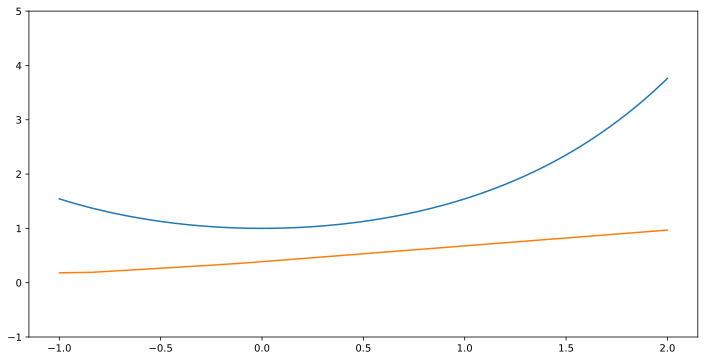

In [101]:
# this is the approximator with initial weights
demo_function_approximation(num_functions=K, static=True, default_transform="relu", **coeffs_before)

MSE: 0.06416614742399629


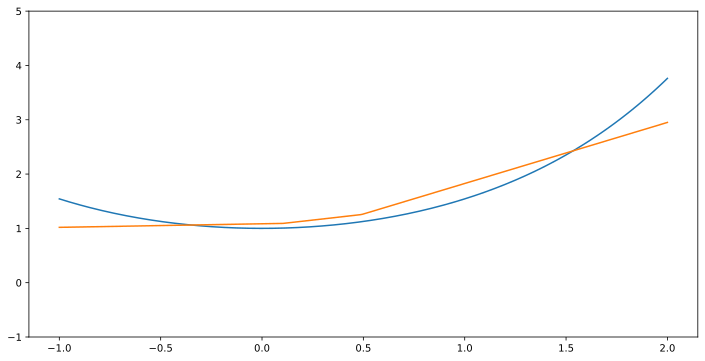

In [102]:
# this is the approximator after training
demo_function_approximation(num_functions=K, static=True, default_transform="relu", **coeffs_after)

<!--@slideshow slide-->
# XOR problem: add more layers

_Classification_ is also a function approximation problem (for functions with finite number of values).

<!--@slideshow slide-->
Consider the function "exclusive OR" (XOR):
$$
\mathrm{XOR}(x, y) = \begin{cases}1, & x \cdot y < 0\\-1,&\text{otherwise}\end{cases}
$$

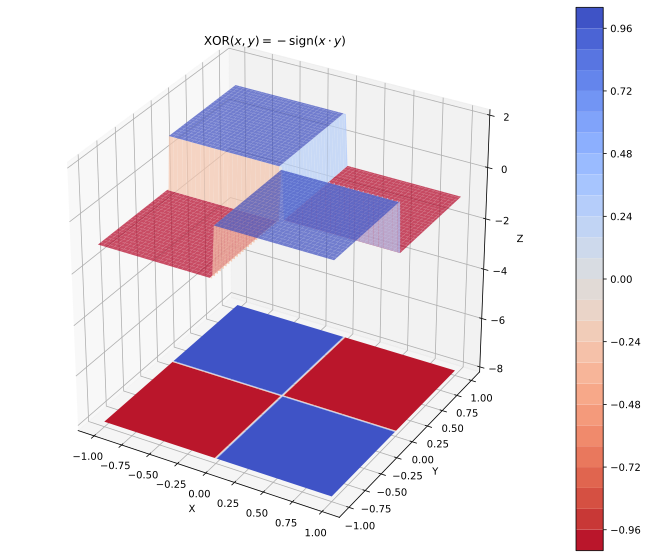

In [103]:
#@slideshow slide tags=remove_input
import numpy as np
f_xor = lambda x, y: -np.sign(x*y)
demo_2d_classification(f_xor, title=r"$\mathrm{XOR}(x, y) = -\mathrm{sign}(x \cdot y)$")

<!--@slideshow slide-->
$\mathrm{XOR}$ function is easily approximated with **two hidden layers**.

**Idea**:
- The first hidden layer computes functions $\mathrm{OR}(x, y)$ and $\mathrm{AND}(x, y)$. 
- Compute $$\mathrm{XOR}(x, y) = \mathrm{sign}(\mathrm{OR}(x, y) - \mathrm{AND}(x, y))$$

In other words, **the second layer computes features for the first layer**.

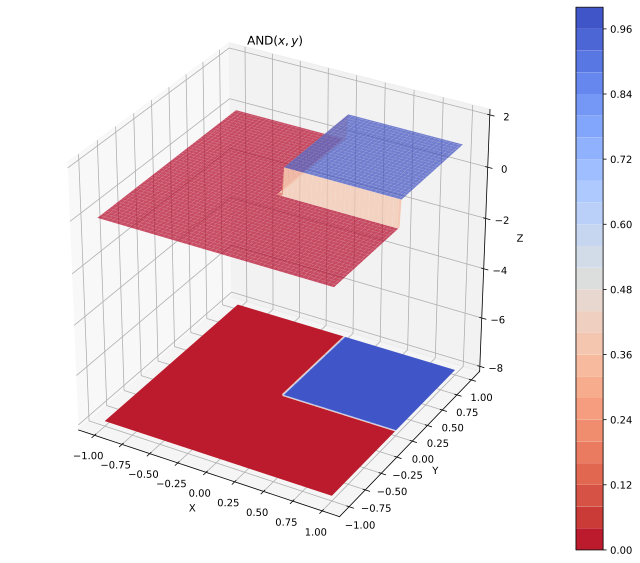

In [104]:
#@slideshow slide tags=remove_input
f_true_and = lambda x, y: (x > 0) * (y > 0)
demo_2d_classification(f_true_and, title=r"$\mathrm{AND}(x, y)$")

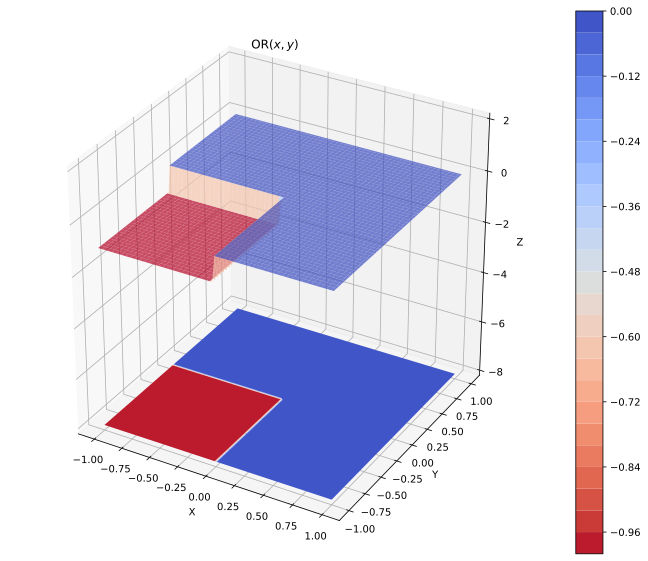

In [105]:
#@slideshow slide tags=remove_input
f_true_or = lambda x, y: (x > 0) + (y > 0) - 1
demo_2d_classification(f_true_or, title=r"$\mathrm{OR}(x, y)$")

<!--@slideshow slide-->
Start with the function $\mathrm{sign}(x) + \mathrm{sign}(y)$:

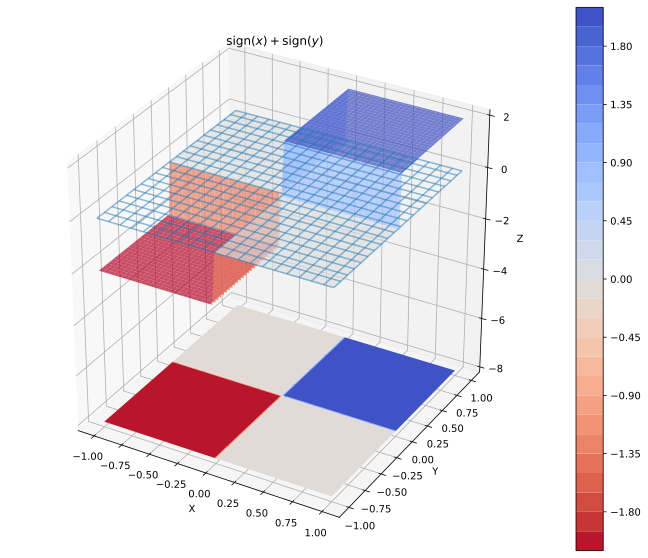

In [106]:
#@slideshow fragment tags=remove_input
f = lambda x, y: np.sign(x) + np.sign(y)
demo_2d_classification(f, show_zero=True, title=r"$\mathrm{sign}(x) + \mathrm{sign}(y)$")

<!--@slideshow slide-->
If we shift all the values down by 1, only one quarter is positive:

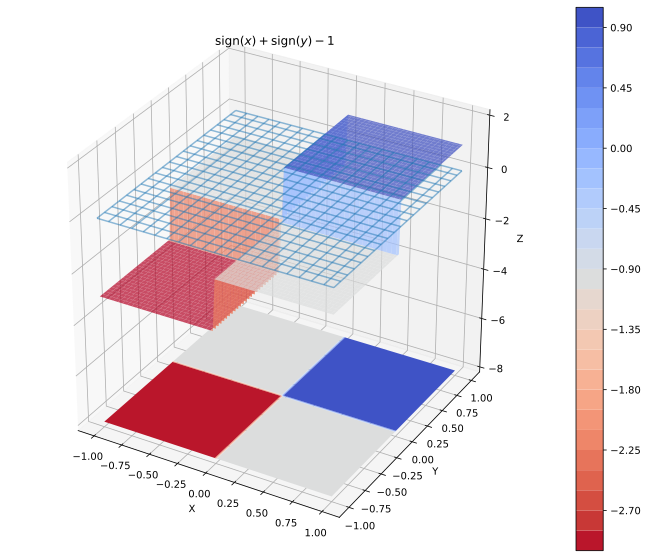

In [107]:
#@slideshow fragment tags=remove_input
f_shifted_down = lambda x, y: np.sign(x) + np.sign(y) - 1
demo_2d_classification(f_shifted_down, show_zero=True, title=r"$\mathrm{sign}(x) + \mathrm{sign}(y) - 1$")

<!--@slideshow slide-->
Taking sign, we obtain $\mathrm{AND}(x, y)$ function:



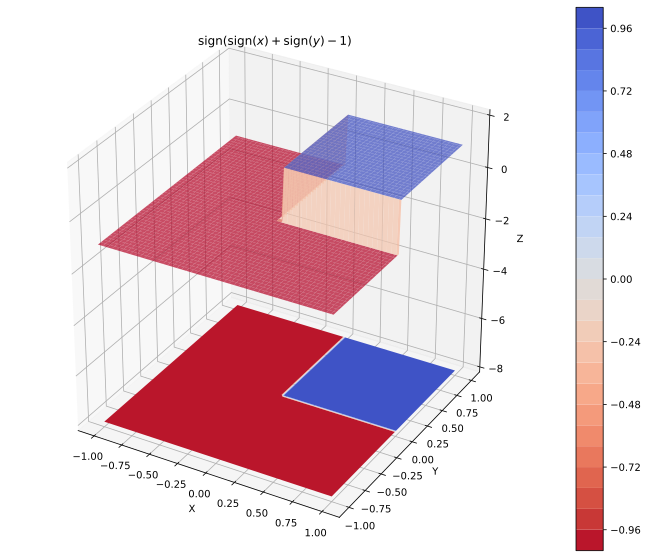

In [108]:
#@slideshow fragment tags=remove_input
f_and = lambda x, y: np.sign(np.sign(x) + np.sign(y) - 1)
demo_2d_classification(f_and, title=r"$\mathrm{sign}(\mathrm{sign}(x) + \mathrm{sign}(y) - 1)$")

<!--@slideshow slide-->
Similarly, we obtain the function $\mathrm{OR}(x, y)$ by shifting up and taking sign:

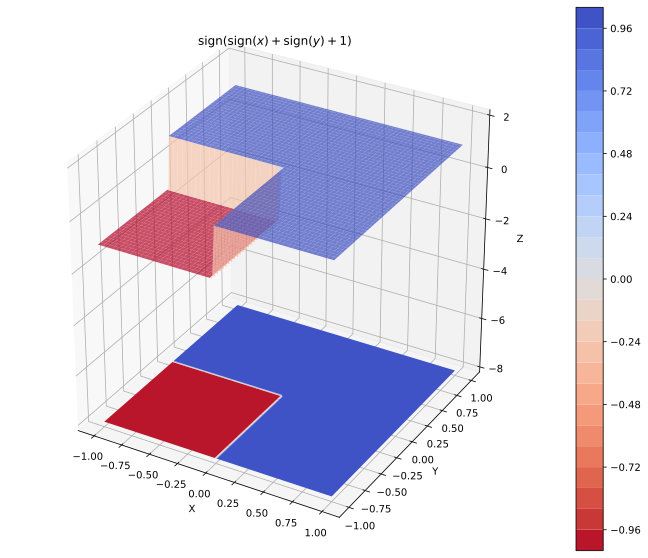

In [109]:
#@slideshow fragment tags=remove_input
f_or = lambda x, y: np.sign(np.sign(x) + np.sign(y) + 1)
demo_2d_classification(f_or, title=r"$\mathrm{sign}(\mathrm{sign}(x) + \mathrm{sign}(y) + 1)$")

<!--@slideshow slide-->
Finally, we get $\mathrm{XOR}(x, y) = \mathrm{sign}(\mathrm{OR}(x, y) - \mathrm{AND}(x, y))$

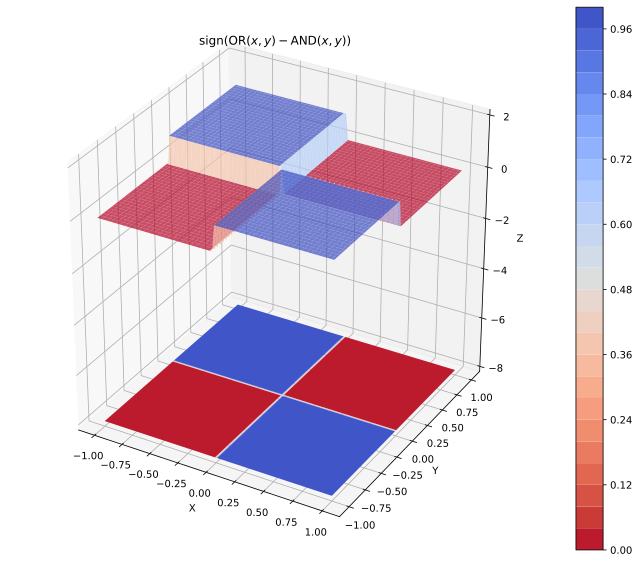

In [110]:
#@slideshow fragment tags=remove_input
approx_f_xor = lambda x, y: np.sign(f_or(x, y) - f_and(x, y))
demo_2d_classification(approx_f_xor, title=r"$\mathrm{sign}(\mathrm{OR}(x, y) - \mathrm{AND}(x, y))$")

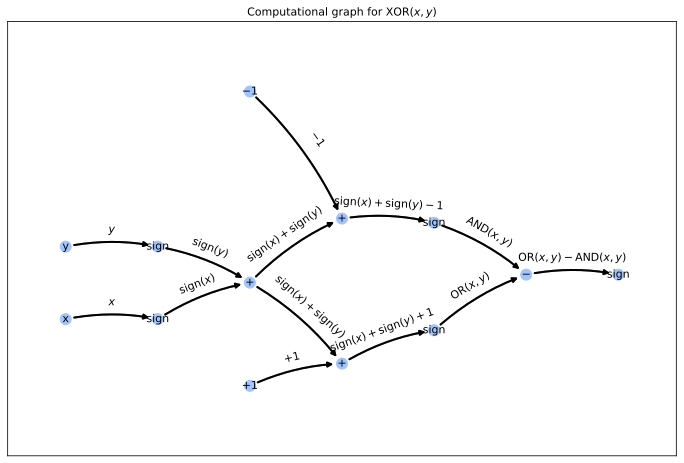

In [111]:
#@slideshow slide tags=remove_input
step_x = "step_x"
step_y = "step_y"
plus_1 = "plus_1"
inc_1 = "inc_1"
dec_1 = "dec_1"
step_and = "step_and"
step_or = "step_or"
minus_1 = "minus_1"
step_xor = "step_xor"

plus_label = r"$+$"
step_label = r"$\mathrm{sign}$"
labels = {
    step_x: step_label,
    step_y: step_label,
    plus_1: plus_label,
    inc_1: plus_label,
    dec_1: plus_label,
    step_and: step_label,
    step_or: step_label,
    minus_1: r"$-$",
    step_xor: step_label,
}
connections = [
    ("x", step_x, r"$x$", ""),
    ("y", step_y, r"$y$", ""),
    (step_x, plus_1, r"$\mathrm{sign}(x)$", ""),
    (step_y, plus_1, r"$\mathrm{sign}(y)$", ""),
    (r"$+1$", inc_1, r"$+1$", ""),
    (plus_1, inc_1, r"$\mathrm{sign}(x) + \mathrm{sign}(y)$", ""),
    (r"$-1$", dec_1, r"$-1$", ""),
    (plus_1, dec_1, r"$\mathrm{sign}(x) + \mathrm{sign}(y)$", ""),
    (inc_1, step_or, r"$\mathrm{sign}(x) + \mathrm{sign}(y) + 1$", ""),
    (dec_1, step_and, r"$\mathrm{sign}(x) + \mathrm{sign}(y) - 1$", ""),
    (step_or, minus_1, r"$\mathrm{OR}(x, y)$", ""),
    (step_and, minus_1, r"$\mathrm{AND}(x, y)$", ""),
    (minus_1, step_xor, r"$\mathrm{OR}(x, y) - \mathrm{AND}(x, y)$", ""),
]
demo_computational_graph(
    connections,
    title=r"$\mathrm{XOR}(x, y)$",
    labels=labels,
    backward_color="w",
    figsize=(12, 8),
    font_size=11,
    scale_x=2.0,
    static=True,
    forward_idx=13
)

<!--@slideshow slide-->
# Feedforward neural networks


<!--@slideshow slide-->
Let's put it all together:


<!--@slideshow fragment-->
- Any function can be approximated as a linear combinantion of nonlinear functions ("the universal approximator").


<!--@slideshow fragment-->
- It is convenient to represent this linear combination as composition of _layers_.


<!--@slideshow fragment-->
- Parameters of layers are adjusted via minimization of loss function using gradient descent.


<!--@slideshow fragment-->
- _Backpropagation_ algorithm is used to compute gradients.


<!--@slideshow fragment-->
- We can add more hidden layers: they extract features for next layers.



<!--@slideshow fragment-->
**Definition**: _feedforward neural network_ is a composition of layers.


<!--@slideshow slide-->
Why is it called "neural network"?
![alt text](https://upload.wikimedia.org/wikipedia/commons/4/44/Neuron3.png)

The simplest mathematical model of a neuron:
- Get a linear combination of inputs.
- The input signal "activates" the axon (Heaviside function: 0 or 1).


<!--@slideshow slide-->
Neural networks are
- powerful approximators
- **computationally efficient**


<!--@slideshow fragment-->
Two types of operations:
- _Elementwise_ computation of nonlinearities
- Matrix addition and multipliction

These operations can be parallelized, which is especially effective on GPU.

<!--@slideshow slide-->
# PyTorch basics

In this course, we will use PyTorch to build and train neural networks.

The main feature of PyTorch is dynamic computational graph. It is especially convenient for text analysis because texts can have arbitrary length.

<!--@slideshow slide-->
## Tensor

Tensor is a multidimensional array (like `numpy.array`).

What is special about tensors in PyTorch:
- Tensor operations can be performed on GPU (we won't cover it yet).
- Tensors can store references to functions which compute them. Moreover, tensors store _gradients_ of these functions.

In [112]:
#@slideshow slide
import torch

In [113]:
#@slideshow fragment
# create 2-dimensional tensor x
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
x

tensor([[1, 2, 3],
        [4, 5, 6]])

In [114]:
#@slideshow fragment
# x contains 2 rows (first dimension) and 3 columns (second dimension)
x.size()

torch.Size([2, 3])

In [115]:
#@slideshow fragment
# we can add two tensors together
x = torch.tensor([1, 2])
y = torch.tensor([3, 4])
x + y

tensor([4, 6])

In [116]:
#@slideshow fragment
# "x + y" is syntactic sugar for torch.add(x, y)
torch.add(x, y)

tensor([4, 6])

In [117]:
#@slideshow slide
# pointwise multiplication
x = torch.tensor([1, 2])
y = torch.tensor([3, 4])
x * y

tensor([3, 8])

In [118]:
#@slideshow fragment
# again, "x * y" is syntactic sugar for torch.mul(x, y)
torch.mul(x, y)

tensor([3, 8])

In [119]:
#@slideshow slide
# broadcasting: a scalar value is added to all values of 2-dimensional tensor
x = torch.tensor([[1, 2], [3, 4]])
x + 3

tensor([[4, 5],
        [6, 7]])

In [120]:
#@slideshow fragment
# broadcasting: add 1-dimensional tensor y to each row of x
x = torch.tensor([[1, 2], [3, 4]])
y = torch.tensor([-1, 1])
print(f"x = {x}")
print(f"y = {y}")
print(f"x + y = {x + y}")

x = tensor([[1, 2],
        [3, 4]])
y = tensor([-1,  1])
x + y = tensor([[0, 3],
        [2, 5]])


In [121]:
#@slideshow fragment
# broadcasting: add 2-dimensional tensor with one column y to each row of x
x = torch.tensor([[1, 2], [3, 4]])
y = torch.tensor([[-1], [1]])
print(f"x = {x}")
print(f"y = {y}")
print(f"x + y = {x + y}")

x = tensor([[1, 2],
        [3, 4]])
y = tensor([[-1],
        [ 1]])
x + y = tensor([[0, 1],
        [4, 5]])


In [122]:
#@slideshow slide
# indexing and slicing

x = torch.tensor([[1, 2], [3, 4]])
print(f"x = {x}")
# access the first column (index 0) of the second row (index 1)
print(f"x[1][0] = {x[1][0]}")
# get a Python number instead of a tensor
print(f"x[1][0].item() = {x[1][0].item()}")
# modify an element of a tensor
x[1][0] = 42
print(f"x = {x}")

x = tensor([[1, 2],
        [3, 4]])
x[1][0] = 3
x[1][0].item() = 3
x = tensor([[ 1,  2],
        [42,  4]])


In [123]:
#@slideshow slide
# sometimes we need to create 2-dimensional matrices from 1-dimensional arrays (and vice versa)
a = torch.tensor([1, 2, 3])
b = a.unsqueeze(0)  # assume that there is the dimension 0 (rows), and add this dimension
c = b.squeeze(0)  # the inverse operation for `unsqueeze`
print(f"a={a}")
print(f"b={b}")
print(f"c={c}")

a=tensor([1, 2, 3])
b=tensor([[1, 2, 3]])
c=tensor([1, 2, 3])


In [124]:
#@slideshow slide
# matrix-vector product
W = torch.tensor([[1., 2.], [3., 4.]])
x = torch.tensor([1., 1.])
print(f"W = {W}")
print(f"x = {x}")
print(f"W * x = {torch.matmul(W, x)}")

W = tensor([[1., 2.],
        [3., 4.]])
x = tensor([1., 1.])
W * x = tensor([3., 7.])


<!--@slideshow slide-->
## Gradients

In [125]:
#@slideshow slide
# if the flag `requres_grad` is set, a tensor starts tracking all operations on it
x = torch.tensor(3.0, requires_grad=True)
y = torch.tensor(2.0)
print(f"x = {x}")
print(f"y = {y}")


x = 3.0
y = 2.0


In [126]:
#@slideshow fragment
z = x * y
print(f"z = {z}")
# note that z has the `grad_fn` attribute
# z.grad_fn is a function which computes the gradients of z wrt its inputs
print(f"z.grad_fn = {z.grad_fn}")

z = 6.0
z.grad_fn = <MulBackward0 object at 0x7f9f19bdcf40>


In [127]:
#@slideshow slide
# compute derivatives of z wrt all inputs that have `requres_grad` flag
# the method `.backward()` accepts the initial value for backpropagation
# in this case, it is dz/dz == 1.0
z.backward(torch.tensor(1.0))  # is equivalent to z.backward() since z is a scalar

# dz/dx is computed since g.requires_grad is True
# the gradient dz/dx is stored as the x.grad property
print(f"dz/dx = {x.grad}")
# dz/dy is not computed since g.requires_grad is False
print(f"dz/dy = {y.grad}")

dz/dx = 2.0
dz/dy = None


<!--@slideshow slide-->
Let's look how PyTorch creates computational graphs



In [128]:
#@slideshow fragment
# consider the function z(x, y) = x * (x + y)
x = torch.tensor(3.0, requires_grad=True)
y = torch.tensor(2.0)
z = x * (x + y)

# z.grad_fn is the gradient of product (MulBackward0)
print(f"z.grad_fn = {z.grad_fn}")
# z.grad_fn is designed for backpropagation:
#  - receives the "outer" gradient d something / dz
#  - computes dz / di for all inputs i
#  - returns d something / di for all inputs i
print(f"z.grad_fn(1) = {z.grad_fn(torch.tensor(1.0))}")  # d something / dz = dz/dz = 1

# z.grad_fn stores edges to the input functions in the `.next_functions` property
print(f"z.grad_fn.next_functions = {z.grad_fn.next_functions}")

z.grad_fn = <MulBackward0 object at 0x7f9f1996fd60>
z.grad_fn(1) = (tensor(5., grad_fn=<MulBackward0>), tensor(3., grad_fn=<MulBackward0>))
z.grad_fn.next_functions = ((<AccumulateGrad object at 0x7f9f1996f100>, 0), (<AddBackward0 object at 0x7f9f1996f550>, 0))


<!--@slideshow slide-->
Visualize the computational graph for $z(x, y) = x \cdot (x + y)$.

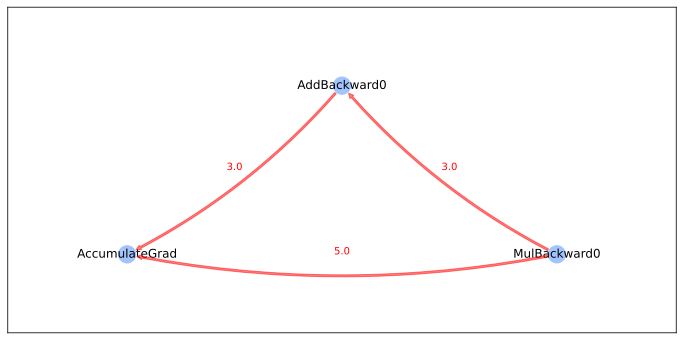

In [129]:
#@slideshow fragment
x = torch.tensor(3.0, requires_grad=True)
y = torch.tensor(2.0)
z = x * (x + y)
# dz / dx = (x + y) + x = 8
demo_pytorch_computational_graph(z)

<!--@slideshow slide-->
Visualize the computational graph for $z(x, y) = x^2 + xy$.

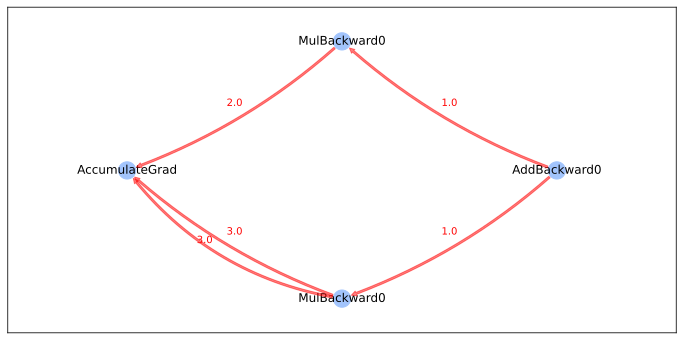

In [130]:
#@slideshow fragment
x = torch.tensor(3.0, requires_grad=True)
y = torch.tensor(2.0)
z = x * x + x * y
# dz / dx = 2x + y = 8
demo_pytorch_computational_graph(z)

<!--@slideshow slide-->
The computational graph for $z(x, y) = x \cdot (x + y)$, both $x$ and $y$ track the gradients.

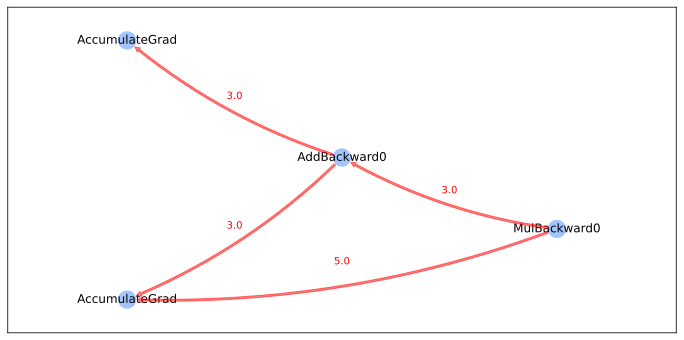

In [131]:
#@slideshow fragment
x = torch.tensor(3.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)
z = x * (x + y)
# dz / dx = (x + y) + x = 8
# dz / dy = x = 3
demo_pytorch_computational_graph(z)

<!--@slideshow slide-->
### Colab quiz 4

Compute the derivative of $f(x) = x^x$ with PyTorch.

In [132]:
def solution(x: float) -> float:
    """
    return the derivative of f(x) = x^x
    """
    # YOUR CODE HERE
    return 1

derivative_pytorch_checker = quiz_derivative_pytorch()
derivative_pytorch_checker(solution)

<!--@slideshow slide-->
## Colab demo: implement the universal approximator using PyTorch layers

As we saw earlier, it's convenient to group computations into _layers_.
PyTorch contains implementations of many standard layers in the module `torch.nn`.

PyTorch also provides a useful abstraction `torch.nn.Module` that allows to compose layers together.

Let's implement the universal approximator
$$
h(x) = \sum\limits_{1 \leq i \leq K} w_k g(a_k x + b_k)
$$
in PyTorch.

### `nn.Module`

In [133]:
import torch
from torch import nn

class H(nn.Module):
    # this class represents the universal approximator
    def __init__(self, K):
        super().__init__()
        # the universal approximator has a hyperparameter K
        # for simplicity, we assume that the nonlinearity is always ReLU

        # we will store the parameters a_k, b_k, w_k in tensors
        # these tensors must be wrapped in `nn.Parameter` class
        # (otherwise PyTorch won't understand that they should be trained)
        # initialize W with a 1d-tensor with K random elements
        # always seed the RNG for reproducibility
        torch.manual_seed(0)
        # A is a K x 1 matrix (1 input, K outputs)
        # B is a vector with K components
        self.A = nn.Parameter(torch.rand(K, 1) - 0.5)
        self.B = nn.Parameter(torch.rand(K) - 0.5)
        # W is 1 x K matrix (K inputs, 1 output)
        self.W = nn.Parameter(torch.rand(1, K) - 0.5)

    def forward(self, x):
        # as we know, PyTorch computes the gradients automatically for all standard operations with tensors
        # so it is enough to provide only forward pass in forward/backward API
        nonlinearity = torch.relu(torch.matmul(self.A, x) + self.B)
        output = torch.matmul(self.W, nonlinearity)
        return output

In [134]:
K = 10
h = H(K)
# note that all parameters (W, A, B) automatically require gradients
print("h.W =", h.W)
print("h.A =", h.A)
print("h.B =", h.B)

# compute some values
# note that x must be 1-dimensional tensor (vector with 1 component)
x1 = torch.tensor([2.])
print("h(2) =", h(x1))
x2 = torch.tensor([-1.])
print("h(-1) =", h(x2))

h.W = Parameter containing:
tensor([[ 0.1816,  0.4152, -0.1029,  0.3742, -0.0806,  0.0529,  0.4527, -0.4638,
         -0.3148, -0.1266]], requires_grad=True)
h.A = Parameter containing:
tensor([[-0.0037],
        [ 0.2682],
        [-0.4115],
        [-0.3680],
        [-0.1926],
        [ 0.1341],
        [-0.0099],
        [ 0.3964],
        [-0.0444],
        [ 0.1323]], requires_grad=True)
h.B = Parameter containing:
tensor([-0.1511, -0.0983, -0.4777, -0.3311, -0.2061,  0.0185,  0.1977,  0.3000,
        -0.3390, -0.2177], requires_grad=True)
h(2) = tensor([-0.2352], grad_fn=<MvBackward0>)
h(-1) = tensor([0.1078], grad_fn=<MvBackward0>)


In [135]:
# fit the function f(x) = cosh(x)
import numpy as np
# generate data
num_samples = 1000
X = np.linspace(-1, 2, num_samples, dtype=np.float32)
Y = np.cosh(X)

# train using stochastic gradient descent
def train(h, X, Y, num_iterations, learning_rate):
    # we will be minimizing MSE
    loss_function = nn.MSELoss()

    # stochastic gradient descent
    for t in range(num_iterations):
        lr = learning_rate / np.sqrt(t + 1)
        # get random sample
        idx = np.random.choice(range(num_samples))
        # input is a 1-dimensional tensor
        x = torch.tensor([X[idx]])
        # output is a 1-dimensional tensor
        y = torch.tensor([Y[idx]])

        # compute the loss
        loss = loss_function(y, h(x))

        # NB: by default, gradients are always accumulated
        # so for each forward/backward pass they should be zeroed
        h.zero_grad()

        # compute the backward pass
        loss.backward()

        # update the parameters
        # each parameter update is a function, so in principle we can track its gradients
        # but we don't need it, so wrap the parameter update with torch.no_grad()
        with torch.no_grad():
            # h.parameters() is the iterator over all the parameters
            # each parameter contains the gradient afer backprop in the .grad property
            for parameter in h.parameters():
                parameter -= lr * parameter.grad

num_iterations = 10000
learning_rate = 0.05
train(h, X, Y, num_iterations, learning_rate)

MSE: 0.02957884467107005


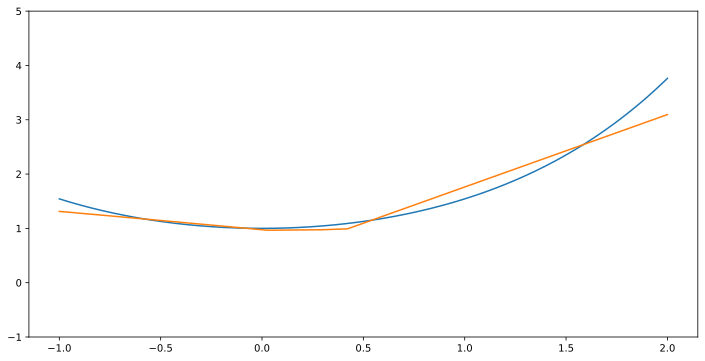

In [136]:
# visualize
coeffs = {}
for i, par in enumerate(zip(h.W.squeeze(), h.A.squeeze(), h.B.squeeze())):
    w, a, b = par
    coeffs["w" + str(i+1)] = w.item()
    coeffs["a" + str(i+1)] = a.item()
    coeffs["b" + str(i+1)] = b.item()
demo_function_approximation(num_functions=K, static=True, default_transform="relu", **coeffs)

### `nn.Sequential`

Feedforward neural networks can be implemented using `nn.Sequential`:

In [137]:
h2 = nn.Sequential(
    nn.Linear(1, K),  # nn.Linear is a linear transformation: 1 input, K outputs
    nn.ReLU(),  # apply ReLU to the output of the previous layer
    nn.Linear(K, 1, bias=False)  # K inputs from the previous layer, 1 output. Do not add bias
)
train(h2, X, Y, num_iterations, learning_rate)

MSE: 0.014025422981475678


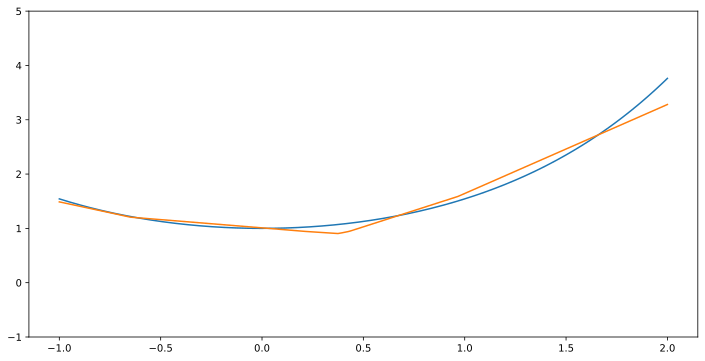

In [138]:
# visualize
A, B, W = list(h2.parameters())

coeffs = {}
for i, par in enumerate(zip(W.squeeze(), A.squeeze(), B.squeeze())):
    w, a, b = par
    coeffs["w" + str(i+1)] = w.item()
    coeffs["a" + str(i+1)] = a.item()
    coeffs["b" + str(i+1)] = b.item()
demo_function_approximation(num_functions=K, static=True, default_transform="relu", **coeffs)

<!--@slideshow slide-->
# Summary
1. Any function can be approximated with just one nonlinearity.
2. Parameters of approximation can be found by minimization of loss function with gradient descent.
3. Gradients are efficiently computed using backpropagation algorithm on the computational graph.
4. Computations are grouped in layers with forward-backward API.
5. More layers help to extract features.
6. Feedforward neural networks are powerful (can approximate any function) and computationally efficient.
7. PyTorch basics: tensors, autogradients, modules.

<!--@slideshow slide-->
# Recommended resources

Backpropagation
- 
[📖 CS231n: backpropagation](https://cs231n.github.io/optimization-2/)
- [📖 Yes you should understand backprop](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b)

GPU
- [📺 CPU vs GPU (What's the Difference?) - Computerphile
](https://www.youtube.com/watch?v=_cyVDoyI6NE)

PyTorch
- [📺 "PyTorch: Fast Differentiable Dynamic Graphs in Python" by Soumith Chintala](https://www.youtube.com/watch?v=DBVLcgq2Eg0)


<!--@slideshow slide-->
`torch.autograd`
- https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html
- https://pytorch.org/docs/stable/notes/autograd.html#how-autograd-encodes-the-history
- https://towardsdatascience.com/pytorch-autograd-understanding-the-heart-of-pytorchs-magic-2686cd94ec95

`torch.nn`
- https://pytorch.org/tutorials/beginner/nn_tutorial.html#